In [1]:
!pip install pmdarima

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
import datetime as dt
from datetime import timedelta

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
from pmdarima.arima import AutoARIMA as auto_arima

## Importing the dataset

In [3]:
df = pd.read_csv('ventas_weather_dataset.csv')
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.set_index('fecha')
df.head()

,Unnamed: 0,DESH. ESP.,CHICH. MIXTO,CHICH. ESP,DESH. PURA,Zanahoria,CHICH. PURO,DESH. 90,DESH. 80,CHICH. CHAR,DESH. ECO,DESH. CHAR,Manteca,Tocino,CUERO RUTA 5k,Trompo Medio,CUERO RUTA 2k,CUERO NAT,Trompo Kilo,temp_max,temp_avg,temp_min,humidity_max,humidity_avg,humidity_min,weekday
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-03,0,0,197,16,0,0,0,0,11,0,226,0,87,0,13,0,0,5,0,34,27.6,22,94,66.9,36,0
2020-08-04,1,0,75,21,0,0,0,5,7,0,134,0,172,0,2,0,0,5,0,33,27.3,22,100,71.3,36,1
2020-08-05,2,0,170,84,0,0,0,0,13,0,184,0,76,0,7,0,2,6,0,32,27.4,23,100,76.5,52,2
2020-08-06,3,0,150,16,7,0,0,0,0,0,174,10,61,0,2,0,0,5,0,33,27.7,24,89,72.2,49,3
2020-08-07,4,0,207,46,0,0,0,0,13,0,224,0,127,0,7,0,1,12,0,33,27.7,24,94,72.2,49,4


In [4]:
df['weekday'] = df.weekday.apply(str)
X = df[['weekday','temp_max', 'temp_avg','temp_min','humidity_max','humidity_avg','humidity_min']]
y = df['DESH. ECO']

In [5]:
X

,weekday,temp_max,temp_avg,temp_min,humidity_max,humidity_avg,humidity_min
fecha,,,,,,,
2020-08-03,0,34,27.6,22,94,66.9,36
2020-08-04,1,33,27.3,22,100,71.3,36
2020-08-05,2,32,27.4,23,100,76.5,52
2020-08-06,3,33,27.7,24,89,72.2,49
2020-08-07,4,33,27.7,24,94,72.2,49
...,...,...,...,...,...,...,...
2021-02-24,2,32,22.4,13,94,61.1,31
2021-02-25,3,32,23.4,15,94,61.5,31
2021-02-26,4,26,21.7,18,88,70.3,54


In [6]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=y.index, y=y,
                    mode='lines+markers',name="Sales"))
fig.update_layout(title="Food retail supplier sales",
                 xaxis_title="Date",yaxis_title="Sales",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

#  

In [7]:
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.555590
p-value: 0.006669
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


## Splitting the dataset into the Training set and Test set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle=False)

# Time Series Forecasting

In [9]:
model_scores = []
y_pred = {}

## Holts Model

In [10]:
holt = Holt(y_train).fit(smoothing_level=.1, smoothing_slope=.1, optimized=True)   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [11]:
y_pred["Holt"] = holt.forecast(len(y_test))
model_scores.append(np.sqrt(mean_squared_error(y_test, y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ", np.sqrt(mean_squared_error(y_test,y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  83.38174137758119


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [12]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                    mode='lines+markers',name="Train Data"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                    mode='lines+markers',name="Real Data",))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction",))
fig.update_layout(title="Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Sales",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## Holts Winter model

In [13]:
es = ExponentialSmoothing(y_train,seasonal_periods=7,trend='add', seasonal='add').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [14]:
y_pred["Holt's Winter Model"] = es.forecast(len(y_test))
model_scores.append(np.sqrt(mean_squared_error(y_test,y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_test,y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  82.25877114702062


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [15]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                    mode='lines+markers',name="Train Data"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                    mode='lines+markers',name="Real Data",))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction",))
fig.update_layout(title="Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Sales",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

# AR Model

In [16]:
model_ar = auto_arima(trace=True, error_action='ignore', start_p=0, start_q=0,max_p=4,max_q=0, suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(y_train)
prediction_ar = model_ar.predict(len(y_test))
y_pred["AR Model Prediction"] = prediction_ar
model_scores.append(np.sqrt(mean_squared_error(y_test,y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_test,y_pred["AR Model Prediction"])))

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1626.167, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1611.464, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1611.218, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1590.683, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1562.507, Time=0.16 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0] intercept
Total fit time: 0.388 seconds
Root Mean Square Error for AR Model:  88.59903817154704


In [17]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                    mode='lines+markers',name="Train Data"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                    mode='lines+markers',name="Real Data",))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction",))
fig.update_layout(title="AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Sales",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## MA Model

In [18]:
model_ma = auto_arima(trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,suppress_warnings=True,stepwise=False,seasonal=False, )
model_ma.fit(y_train)
prediction_ma = model_ma.predict(len(y_test))
y_pred["MA Model Prediction"] = prediction_ma
model_scores.append(np.sqrt(mean_squared_error(y_test,prediction_ma)))
print("Root Mean Square Error for MA Model: ", np.sqrt(mean_squared_error(y_test,prediction_ma)))

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1626.167, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.319 seconds
Root Mean Square Error for MA Model:  113.13583466863072


In [19]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                    mode='lines+markers',name="Train Data"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                    mode='lines+markers',name="Real Data",))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction",))
fig.update_layout(title="MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Sales",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## ARIMA Model

In [20]:
model_arima= auto_arima(trace=True, error_action='ignore', start_p=1,start_q=1,max_p=7,max_q=7,suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(y_train)
prediction_arima=model_arima.predict(len(y_test))
y_pred["ARIMA Model Prediction"]=prediction_arima
model_scores.append(np.sqrt(mean_squared_error(y_test,prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(y_test,prediction_arima)))

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1626.167, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1611.464, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1611.218, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1590.683, Time=0.10 sec
 ARI

In [21]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                    mode='lines+markers',name="Train Data"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                    mode='lines+markers',name="Real Data",))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction",))
fig.update_layout(title="ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Sales",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

SARIMA Model

In [22]:
model_sarima = auto_arima(trace=True, error_action='ignore',start_p=0,start_q=0,max_p=7,max_q=7,m=7,suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(y_train)
prediction_sarima=model_sarima.predict(len(y_test))
y_pred["SARIMA Model Prediction"]=prediction_sarima
model_scores.append(np.sqrt(mean_squared_error(y_test,y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_test,y_pred["SARIMA Model Prediction"])))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=1629.886, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1626.167, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1608.214, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1624.173, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1611.464, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1592.704, Time=0.28 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=1589.597, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=1606.685, Time=0.16 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=1585.693, Time=0.95 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=1599.972, Time=0.41 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(2,1,0)(2,0,2)[7] intercept   : AIC=1583.192, Time=1.03 sec
 ARIMA(2,1,0)(1,0,2)[7] intercept   : AIC=1601.426, Time=0.54 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=1

In [23]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                    mode='lines+markers',name="Train Data"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                    mode='lines+markers',name="Real Data",))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction",))
fig.update_layout(title="SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Sales",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### Facebook Prophet Model for forecasting 

In [24]:
prophet_s = Prophet(interval_width=0.95,weekly_seasonality=True)
prophet_df=pd.DataFrame(zip(list(y_train.index),list(y_train)),columns=['ds','y'])
prophet_s.fit(prophet_df)
forecast_s = pd.DataFrame({'ds':y_test.index})
sales_forecast=prophet_s.predict(forecast_s)
model_scores.append(np.sqrt(mean_squared_error(y_test,sales_forecast['yhat'].tail(len(y_test)))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(y_test,sales_forecast['yhat'].tail(len(y_test)))))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Root Mean Squared Error for Prophet Model:  73.76730323330719


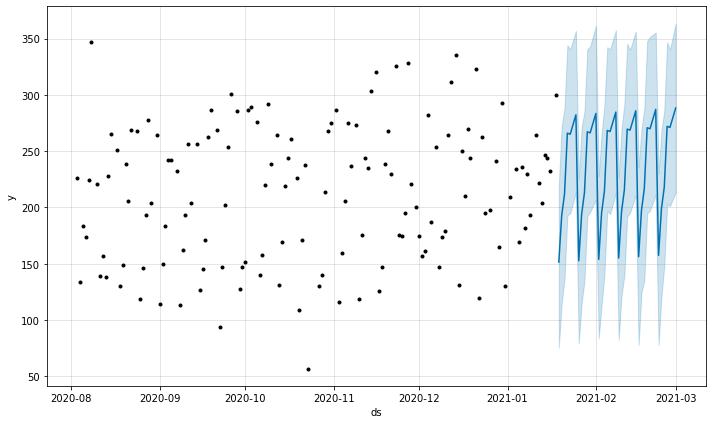

In [25]:
prophet_s.plot(sales_forecast);

In [26]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                    mode='lines+markers',name="Train Data"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                    mode='lines+markers',name="Real Data",))
fig.add_trace(go.Scatter(x=y_test.index, y=sales_forecast['yhat'].tail(len(y_test)),
                    mode='lines+markers',name="Prediction",))
fig.update_layout(title="Prophet Model Prediction",
                 xaxis_title="Date",yaxis_title="Sales",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

# Panel Data

In [27]:
!pip install linearmodels

In [28]:
X1 = df[['weekday','temp_max', 'temp_avg','temp_min','humidity_max','humidity_avg','humidity_min']]
y = df['DESH. ECO']
X1['Product'] = 'DESH. ECO'
X1['Sales'] = y

X2 = df[['weekday','temp_max', 'temp_avg','temp_min','humidity_max','humidity_avg','humidity_min']]
y = df['CHICH. MIXTO']
X2['Product'] = 'CHICH. MIXTO'
X2['Sales'] = y

# X3 = df[['weekday','temp_max', 'temp_avg','temp_min','humidity_max','humidity_avg','humidity_min']]
# y = df['Manteca']
# X3['Product'] = 'Manteca'
# X3['Sales'] = y

# X = X1.append(X2).append(X3)
X = X1.append(X2)

In [29]:
X = X.reset_index()
X = X.set_index(['Product', 'fecha'])
X

weekday  temp_max  ...  humidity_min  Sales
Product      fecha                         ...                     
DESH. ECO    2020-08-03       0        34  ...            36    226
             2020-08-04       1        33  ...            36    134
             2020-08-05       2        32  ...            52    184
             2020-08-06       3        33  ...            49    174
             2020-08-07       4        33  ...            49    224
...                         ...       ...  ...           ...    ...
CHICH. MIXTO 2021-02-24       2        32  ...            31    240
             2021-02-25       3        32  ...            31    102
             2021-02-26       4        26  ...            54    363
             2021-02-27       5        27  ...            36     97
             2021-03-01       0        24  ...            49    208

[354 rows x 8 columns]

In [30]:
y = X['Sales']
X = X.drop(columns='Sales').sort_values(by='fecha')
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
# X = np.array(ct.fit_transform(X))
X_train2, X_test2, y_train2, _ = train_test_split(X, y, test_size = 0.205, random_state = 0, shuffle=False)


In [31]:
from linearmodels.panel import PooledOLS
import statsmodels.api as sm

exog = sm.add_constant(X_train2)
mod = PooledOLS(y_train2, exog)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  Sales   R-squared:                        0.0766
Estimator:                  PooledOLS   R-squared (Between):             -0.0760
No. Observations:                 281   R-squared (Within):              -0.0150
Date:                Wed, Jun 02 2021   R-squared (Overall):              0.0766
Time:                        19:42:52   Log-likelihood                   -1574.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.0295
Entities:                           2   P-value                           0.0260
Avg Obs:                       140.50   Distribution:                  F(11,269)
Min Obs:                       104.00                                           
Max Obs:                       177.00   F-statistic (robust):             2.0295
                            

In [32]:
exog2 = sm.add_constant(X_test2.filter(like='DES', axis=0))
prediction_pooled_ols = pooled_res.predict(exog2)
y_pred["PooledOLS Model Prediction"]=prediction_pooled_ols['predictions']
model_scores.append(np.sqrt(mean_squared_error(y_test,y_pred["PooledOLS Model Prediction"])))
print("Root Mean Square Error for PooledOLS Model: ",np.sqrt(mean_squared_error(y_test,y_pred["PooledOLS Model Prediction"])))

Root Mean Square Error for PooledOLS Model:  94.09932034194709


In [33]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                    mode='lines+markers',name="Train Data"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                    mode='lines+markers',name="Real Data",))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred["PooledOLS Model Prediction"],
                    mode='lines+markers',name="Prediction",))
fig.update_layout(title="PooledOLS Model Prediction",
                 xaxis_title="Date",yaxis_title="Sales",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [34]:
from linearmodels.panel import RandomEffects

mod = RandomEffects(y_train2, exog)
re_res = mod.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  Sales   R-squared:                        0.0766
Estimator:              RandomEffects   R-squared (Between):             -0.0760
No. Observations:                 281   R-squared (Within):              -0.0150
Date:                Wed, Jun 02 2021   R-squared (Overall):              0.0766
Time:                        19:42:52   Log-likelihood                   -1574.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.0295
Entities:                           2   P-value                           0.0260
Avg Obs:                       140.50   Distribution:                  F(11,269)
Min Obs:                       104.00                                           
Max Obs:                       177.00   F-statistic (robust):             2.0295
                            

In [35]:
prediction_re_res = re_res.predict(exog2)
y_pred["RandomEffects Model Prediction"]=prediction_re_res['predictions']
model_scores.append(np.sqrt(mean_squared_error(y_test,y_pred["RandomEffects Model Prediction"])))
print("Root Mean Square Error for RandomEffects Model: ",np.sqrt(mean_squared_error(y_test,y_pred["RandomEffects Model Prediction"])))

Root Mean Square Error for RandomEffects Model:  94.09932034194709


In [36]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                    mode='lines+markers',name="Train Data"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                    mode='lines+markers',name="Real Data",))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred["RandomEffects Model Prediction"],
                    mode='lines+markers',name="Prediction",))
fig.update_layout(title="RandomEffects Model Prediction",
                 xaxis_title="Date",yaxis_title="Sales",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
X = df[['weekday','temp_max', 'temp_avg','temp_min','humidity_max','humidity_avg','humidity_min']]
y = df['DESH. ECO']
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle=False)

In [39]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
lr_y_pred = regressor.predict(X_test)

In [40]:
r_sq = regressor.score(X_test, y_test)
print('R Square test set: ', r_sq)

R Square test set:  0.10197780700538739


In [41]:
y_pred["LinearRegression Model Prediction"]=lr_y_pred
model_scores.append(np.sqrt(mean_squared_error(y_test,lr_y_pred)))
print("Root Mean Square Error for LinearRegression Model: ",np.sqrt(mean_squared_error(y_test,lr_y_pred)))

Root Mean Square Error for LinearRegression Model:  77.48609753313171


In [42]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                    mode='lines+markers',name="Train Data"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                    mode='lines+markers',name="Real Data",))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred["LinearRegression Model Prediction"],
                    mode='lines+markers',name="Prediction",))
fig.update_layout(title="LinearRegression Model Prediction",
                 xaxis_title="Date",yaxis_title="Sales",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [43]:
model_names = ["Holt's Linear", "Holt's Winter Model", "Auto Regressive Model (AR)",
               "Moving Average Model (MA)", "ARIMA Model", "SARIMA Model", "Facebook Prophet Model",
               'PooledOLS', 'RandomEffects', 'LinearRegression']
model_summary = pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary.set_index(['Model Name'], inplace=True)
model_summary.sort_values(['Root Mean Squared Error'], inplace=True)
model_summary

,Root Mean Squared Error
Model Name,
Facebook Prophet Model,73.767303
LinearRegression,77.486098
Holt's Winter Model,82.258771
ARIMA Model,82.764612
Holt's Linear,83.381741
Auto Regressive Model (AR),88.599038
SARIMA Model,89.938248
PooledOLS,94.099320
RandomEffects,94.099320
